# Network Analysis 

### Problem:

1. Use Twitter API to collect 1000 tweets in which keyword ‘narendra modi’ appears, save the collected tweets in nm.txt

2. Convert the collected tweets into BoW vectors and find cosine similarity of a pair of tweets and print the top-10 most similar tweet pairs, print these pairs

3. Do the same using TF-IDF vectors

4. Find out unique users (N) who have posted these 1000 tweets. (N <= 1000)
    U1, u2, ….., uN
5. Find the followers and followee of each user from the N users obtained before
    * u1 - [followers list] [followee list]
    * u2 - [followers list] [followee list]
    * .
    * .
    * uN - [followers list] [followee list]
6. Followers and followees are also users, so create a follower-followee directed graph among them, G. (ui → uj) iff ui is followed by uj
7. Find popular users in this G based on 
    * Degree centrality
    * Betweeness centrality
    * Closeness centrality


---

**Step 1** Use Twitter API to collect 1000 tweets in which keyword ‘narendra modi’ appears, save the collected tweets in nm.txt

In [1]:
# import libraries

import tweepy
import json
import csv
import pandas as pd
import numpy as np
import time

In [2]:
# Twitter API Credentials

from secrets import *

In [3]:
# Stablish connection with API

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [4]:
# Location to store data

data_path = './data/'

In [5]:
# function for searching keyword 
# Attr: search words: word to be searched
#       no_of_tweets: no. of tweets to be fetched
# Ignore retweets

def search_tweets_by_keywords(search_words='narendra modi', max_tweets=1000):
    search_words = search_words + "-filter:retweets"
    search_tweets = tweepy.Cursor(api.search,
                  q=search_words).items(max_tweets)
    return search_tweets

In [6]:
# Saving the tweets as a text file for future reference
# creating a dataframe and converting it to a csv file

def save_tweets_to_text_file(search_tweets, file_name):
    my_list_of_dicts = []
    for each_json_tweet in search_tweets:
        my_list_of_dicts.append(each_json_tweet._json)
        
    with open(data_path + file_name + '.txt', 'w') as file:
        file.write(json.dumps(my_list_of_dicts, indent=4))             

In [7]:
# save id, text, creator's id and creator's name of the tweets
# from text file and create a dataframe and save it in CSV format

def save_required_data_from_txt_to_csv(file_name):
    my_demo_list = []
    with open(data_path + file_name + '.txt', encoding='utf-8') as json_file:
        all_data = json.load(json_file)
        for each_dictionary in all_data:
            tweet_id = each_dictionary['id'] # can also use id_str attr
            text = each_dictionary['text']
            creator_id = each_dictionary['user']['id']
            created_by = each_dictionary['user']['screen_name']
            creator_followers_count = each_dictionary['user']['followers_count']
            creator_friends_count = each_dictionary['user']['friends_count']
            

            my_demo_list.append({'tweet_id': str(tweet_id),
                             'text': str(text),
                             'creator_id': str(creator_id),
                             'created_by': str(created_by),
                             'creator_followers': creator_followers_count,
                             'creator_friends': creator_friends_count,
                            })    
        
            tweet_dataset = pd.DataFrame(my_demo_list, columns = ['tweet_id', 'text', 
                                       'creator_id', 'created_by', 'creator_followers', 'creator_friends'])
            
    # Writing tweet dataset to csv file for future reference
    tweet_dataset.to_csv(data_path + file_name + '.csv', index=False)  

In [8]:
# Collect 1000 tweets with keyword 'narendra modi'

tweets = search_tweets_by_keywords()

In [9]:
# save the tweets in nm.txt file and create dataframe from it

save_tweets_to_text_file(tweets, 'nm')

In [10]:
# Create CSV of required data

save_required_data_from_txt_to_csv('nm')

---

**Step 2** Convert the collected tweets into BoW vectors and find cosine similarity of a pair of tweets and print the top-10 most similar tweet pairs, print these pairs

In [11]:
# Read from CSV

df = pd.read_csv(data_path + 'nm.csv')

In [12]:
df.head()

,tweet_id,text,creator_id,created_by,creator_followers,creator_friends
0,1325834282225471500,West Bengal CM requests @narendramodi to help ...,990761677,MumbaiMirror,394610,236
1,1325834237874876417,My next Prime Minister is not Narendra Modi.\n...,2982502830,Awadhtrk,129,2507
2,1325834202076467200,‘महादेव की काशी कभी थमती नहीं’: PM मोदी ने वार...,972052524449505280,ShreeP1960,770,1579
3,1325834086296870912,@narendramodi \n@narendramodi \nDear Narendra ...,1270742819947384834,PNirmql,0,37
4,1325834001584680960,पीएम मोदी ने एक ट्वीट कर कहा है-मेरा आग्रह है ...,2895345258,HindiNews18,198247,64


In [13]:
df.shape
df.describe()

,tweet_id,creator_id,creator_followers,creator_friends
count,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000
mean,1.325767e+18,7.138795e+17,1.229968e+05,679.058000
std,3.684144e+13,5.792779e+17,9.185981e+05,1784.448879
min,1.325701e+18,6.509832e+06,0.000000e+00,0.000000
25%,1.325738e+18,1.258551e+09,1.175000e+01,51.000000
50%,1.325768e+18,9.899347e+17,1.400000e+02,181.500000
75%,1.325799e+18,1.275969e+18,1.084000e+03,592.250000
max,1.325834e+18,1.325797e+18,1.135083e+07,24946.000000


### Bag of Words vector

In [14]:
# tokenize texts to get meaningful words
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
# list of Tweet's text

text = list(df['text'])

In [16]:
vectorizer = CountVectorizer()

In [17]:
# tokenize and build vocab

vectorizer.fit(text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [18]:
# summarize

print(vectorizer.vocabulary_)

{'indore': 1676, 'kamalaharris': 1888, 'qeey3exp9n': 2815, 'sanjukta': 3068, 'guys': 1441, '145th': 22, 'xzxxeg1mu8': 3883, '_ashwatthama_': 189, 'ರತ': 4434, 'jasodaben': 1784, 'एक': 4042, 'darbara': 912, 'needed': 2388, 'ngl': 2404, 'have': 1492, 'vaiko': 3658, 'fools': 1278, 'ambani': 328, 'eumes6xyxl': 1170, 'ટલ': 4319, 'ggalpoj8it': 1356, 'gy6gfaule1': 1446, 'লয': 4288, 'ranbir_crpf': 2876, 'jnuchaap': 1827, 'bharat28chopra': 573, 'yogi': 3919, 'jyotiraju09': 1868, 'kbkkcg57h2': 1917, 'janata': 1777, 'potatoes': 2710, 'kalla': 1883, 'freedanicholas': 1301, 'cheap': 769, 'or': 2525, 'befall': 539, 'muhammad': 2301, 'महत': 4172, 'वल': 4202, '5lioa8w90n': 111, 'thackrey': 3437, 'real_goswami5': 2897, 'indianeconomy': 1666, 'amreli': 343, '73': 135, 'sakte': 3049, 'respect': 2956, 'खर': 4067, 'ruptures': 3017, 'bachpan': 483, 'આપણ': 4308, 'deceased': 931, 'delhipolice': 947, 'sorry': 3238, 'infront': 1688, 'mannkibaat': 2169, 'arnablifeunderthreat': 411, 'texminindia': 3427, 'red': 291

In [19]:
# encode document

vector = vectorizer.transform(text)

In [20]:
# summarize encoded vector

print(vector.shape)

(1000, 4464)


In [21]:
print(type(vector))

<class 'scipy.sparse.csr.csr_matrix'>


In [22]:
print(vector.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [23]:
BoW_array = vector.toarray()

In [24]:
BoW_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### TF-IDF Vector

In [25]:
# tfidf vectorize

from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
tfidf_vectorizer = TfidfVectorizer()

In [27]:
tfidf_vector = tfidf_vectorizer.fit_transform(text)

In [28]:
tfidf_vector.shape

(1000, 4464)

In [29]:
tfidf_array = tfidf_vector.toarray()

In [30]:
tfidf_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Cosine Similarity

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

In [32]:
# Cosine Similarity function

def Cosine_Similarity(arr):
    tweet_similarity = []

    for i in range(len(arr)):
        tweet_similarity_row = []
        for j in range(len(arr)):
            a = np.reshape(arr[i], (1, arr[i].size))
            b = np.reshape(arr[j], (1, arr[j].size))
            c = cosine_similarity(a,b)
            tweet_similarity_row.append(c[0][0])
        tweet_similarity.append(tweet_similarity_row) 
    return tweet_similarity

In [33]:
# Call Cosine Similarity function for BoW vector

BoW_similarity = Cosine_Similarity(BoW_array)

In [34]:
len(BoW_similarity)

1000

In [35]:
len(BoW_similarity[0])

1000

In [36]:
# Find pair which are most similar and creating dataframe
# excluding similarity of one tweet with itself
# and considering the pair only once i.e checking (a, b) but not (b, a)

def similar_pairs(similarity_array):
    row_col_similarity = []

    for i in range(len(similarity_array)):
        for j in range(i, len(similarity_array)):
            if i != j:
                row_col_similarity.append([i, j, similarity_array[i][j]])
    
    # Create the pandas DataFrame 
    similarity_df = pd.DataFrame(row_col_similarity, columns = ['Tweet1 index', 'Tweet2 index', 'cosine similarity'])
    return similarity_df

In [37]:
# Call similarity pair for BoW_similarity

BoW_similarity_df = similar_pairs(BoW_similarity)

In [38]:
# Top 10 similar tweets

top_10_BoW_df = BoW_similarity_df.nlargest(10, 'cosine similarity')

In [39]:
top_10_BoW_df.reset_index(drop=True)

,Tweet1 index,Tweet2 index,cosine similarity
0,57,58,1.0
1,194,199,1.0
2,210,403,1.0
3,210,458,1.0
4,210,460,1.0
5,210,475,1.0
6,210,481,1.0
7,210,485,1.0
8,210,486,1.0
9,403,458,1.0


In [40]:
df.iloc[398, 1]

'What a Biden Administration Could Do – Or Not Do – for India’s Key Priorities https://t.co/YBP4t0bHjV'

## Similar tweets pair using BoW

In [41]:
# Print top 10 similar tweet pairs

def print_tweet_pairs(top_10_df):
    for i in range(len(top_10_df)):
        print("\nTweet pair ", i+1)
        t1 = top_10_df.iloc[i, 0] # Tweet1 index in ith row
        t2 = top_10_df.iloc[i, 1] # Tweet2 index in ith row
        print("Tweet1")
        print(df.iloc[t1, 1]) # text at t1 index in df
        print("Tweet2")
        print(df.iloc[t2, 1]) # text at t2 index in df
        print("\n************************************************************")

In [42]:
print_tweet_pairs(top_10_BoW_df)


Tweet pair  1
Tweet1
प्रधानमंत्री ने उत्‍तराखंड के निवासियों को राज्‍य के स्‍थापना दिवस पर बधाई दी
https://t.co/WdWcc2GZ80
via NaMo App
Tweet2
प्रधानमंत्री ने उत्‍तराखंड के निवासियों को राज्‍य के स्‍थापना दिवस पर बधाई दी
https://t.co/WdWcc2GZ80
via NaMo App

************************************************************

Tweet pair  2
Tweet1
@BJP4India Narendra Modi chur hai.....
Tweet2
@BJP4India Narendra Modi chur hai...

************************************************************

Tweet pair  3
Tweet1
@republic Ppl in United states , u voice it to the president there so he urges narendra modi to take action
Tweet2
@republic Ppl in United states , u voice it to the president there so he urges narendra modi to take action

************************************************************

Tweet pair  4
Tweet1
@republic Ppl in United states , u voice it to the president there so he urges narendra modi to take action
Tweet2
@republic Ppl in United states , u voice it to the president there s

## Similar tweets pair using TF-IDF


In [44]:
tfidf_similarity = cosine_similarity(tfidf_array)
tfidf_similarity_df = similar_pairs(tfidf_similarity)
top_10_tfidf_df = tfidf_similarity_df.nlargest(10, 'cosine similarity')
top_10_tfidf_df.reset_index(drop=True)
print_tweet_pairs(top_10_tfidf_df)


Tweet pair  1
Tweet1
@Republic_Bharat Ppl in United states , u voice it to the president there so he urges narendra modi to take action
Tweet2
@Republic_Bharat Ppl in United states , u voice it to the president there so he urges narendra modi to take action

************************************************************

Tweet pair  2
Tweet1
@GeneralBakshi Ppl in us , u voice it to the president there so he urges narendra modi to take action
Tweet2
@GeneralBakshi Ppl in us , u voice it to the president there so he urges narendra modi to take action

************************************************************

Tweet pair  3
Tweet1
Narendra Modi
Tweet2
Narendra modi

************************************************************

Tweet pair  4
Tweet1
Narendra Modi
Tweet2
Narendra Modi

************************************************************

Tweet pair  5
Tweet1
Narendra modi
Tweet2
Narendra Modi

************************************************************

Tweet pair  6
Tweet1
प्रधा

### Find out unique users (N) who have posted these 1000 tweets. (N <= 1000) U1, u2, ….., uN

In [45]:
# Unique users with followers/friends atmost 1000 (<= 1000)

df_user = df[(df['creator_followers'] <= 1000) & (df['creator_friends'] <= 1000)]
df_user.describe()

,tweet_id,creator_id,creator_followers,creator_friends
count,6.730000e+02,6.730000e+02,673.000000,673.000000
mean,1.325769e+18,8.879432e+17,113.705795,204.833581
std,3.619250e+13,5.356930e+17,180.459688,241.751377
min,1.325702e+18,1.001794e+07,0.000000,0.000000
25%,1.325740e+18,4.896243e+09,3.000000,37.000000
50%,1.325769e+18,1.165962e+18,30.000000,103.000000
75%,1.325800e+18,1.295244e+18,150.000000,293.000000
max,1.325834e+18,1.325797e+18,981.000000,997.000000


In [46]:
unique_creators = df_user.created_by.unique()
unique_creators = list(unique_creators)
len(unique_creators)

478

In [47]:
def limit_handled(cursor, list_name):
    while True:
        try:
            yield cursor.next()
            #print(len(user_list))
        # Catch Twitter API rate limit exception and wait for 15 minutes
        except tweepy.RateLimitError:
            print("Data points in list = {}".format(len(list_name)))
            print("Hit Twitter API rate limit.")
            for i in range(3, 0, -1):
                print("Wait for {} mins.".format(i*5))
                time.sleep(5*60)
        # Catch any other Twitter API exceptions
        except tweepy.error.TweepError:
            print('\nCaught TweepError exception')
            break

In [48]:
# Create a list of followers and friends of these unique creators
#f = ['joongfIrt', 'PrameyaEnglish']

user_list = []
count = 0
for user in unique_creators:
    count = count + 1
    print(count)
    ff_list = []
    followers = []
    for follower in limit_handled(tweepy.Cursor(api.followers, screen_name=user, count=200).items(), user_list):
        followers.append(follower.screen_name)
        #print("followers: ", len(followers))
    
    friends = []
    for friend in limit_handled(tweepy.Cursor(api.friends, screen_name=user, count=200).items(), user_list):
        friends.append(friend.screen_name)    
        #print("friends: ", len(friends))
        
    ff_list = [followers, friends]

    user_list.append(ff_list)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16

Caught TweepError exception
17
18
19
20
21
22
23

Caught TweepError exception
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216

Caught TweepError exception

Caught TweepError exception
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248


In [49]:
len(user_list)

478

### Create Network Graph using NetworkX

Followers and followees are also users, so create a follower-followee directed graph among them, G. (ui → uj) iff ui is followed by uj

In [50]:
#!pip install networkx

import networkx as nx
import matplotlib.pyplot as plt

In [51]:
# Instantiate Graph object (Directed graph)

g = nx.DiGraph()

In [52]:
for i in range(len(user_list)):
    for j in range(len(user_list[i][0])): # For followers
        g.add_edge(unique_creators[i], user_list[i][0][j])
    
    for k in range(len(user_list[i][1])): # For friends
        g.add_edge(user_list[i][1][k], unique_creators[i])

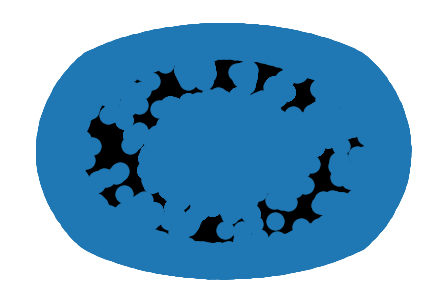

In [53]:
# Draw Graph

nx.draw(g)

In [54]:
plt.savefig('network_graph.png')

<Figure size 432x288 with 0 Axes>

Find popular users in this G based on

* Degree centrality
* Betweeness centrality
* Closeness centrality

In [55]:
d=nx.degree_centrality(g)  

In [56]:
b=nx.betweenness_centrality(g)

In [57]:
c=nx.closeness_centrality(g) 

In [58]:
Keymax_degree = max(d, key=d.get)
Keymax_betweenness = max(b, key=b.get)
Keymax_closeness = max(c, key=c.get)

In [59]:
print('Key with max degree ', Keymax_degree)
print('Key with max betweenness ', Keymax_betweenness)
print('Key with max closeness ', Keymax_closeness)

Key with max degree  dee__jay
Key with max betweenness  DevarshiJoshi17
Key with max closeness  MJNavada
